In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import Binarizer

In [2]:
data_ratings = pd.read_csv('ratings.csv')
data_movies = pd.read_csv('movies.csv')
data_links = pd.read_csv('links.csv')
data_tags = pd.read_csv('tags.csv')

In [3]:
data_movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [4]:
data_tags

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


In [5]:
print(data_links.dtypes) 

movieId      int64
imdbId       int64
tmdbId     float64
dtype: object


In [6]:
data_ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [7]:
data_tags.isnull().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

In [8]:
data_movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [9]:
tags_movie_ids = set(data_tags['movieId'])
movies_movie_ids = set(data_movies['movieId'])

common_ids = tags_movie_ids.intersection(movies_movie_ids)

print(f"Number of matching movieIds: {len(common_ids)}")


Number of matching movieIds: 1572


In [10]:
movies_movie_ids = set(data_movies['movieId'])
ratings_movie_ids = set(data_ratings['movieId'])

common_ids = movies_movie_ids.intersection(ratings_movie_ids)
missing_ids = movies_movie_ids.difference(ratings_movie_ids)

print(f"Number of common movieIds: {len(common_ids)}")
print(f"Number of missing movieIds in ratings: {len(missing_ids)}")

if len(missing_ids) > 0:
    print(f"Missing movieIds: {missing_ids}")
else:
    print("All movies in movies are present in ratings.")

Number of common movieIds: 9724
Number of missing movieIds in ratings: 18
Missing movieIds: {3456, 6849, 4194, 85565, 32160, 26085, 3338, 6668, 7020, 30892, 7792, 34482, 32371, 1076, 5721, 2939, 8765, 25855}


In [11]:
data_movies['genres'] = data_movies['genres'].fillna('').apply(lambda x: ' '.join(x.split('|')))

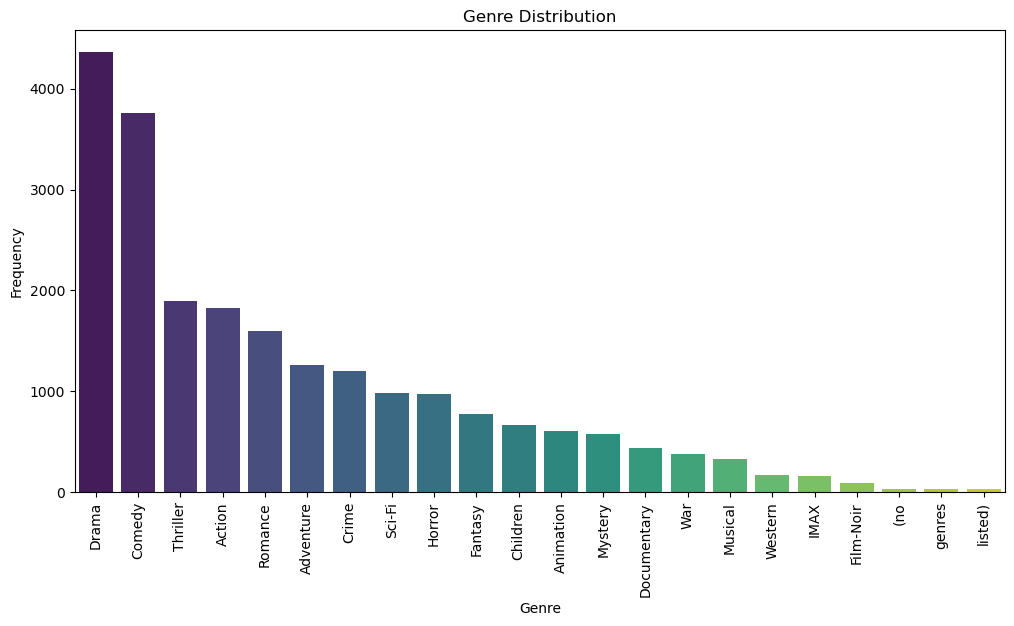

In [12]:
genre_counts = data_movies['genres'].str.split(' ', expand=True).stack().value_counts()

# Plot the genre distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.title('Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

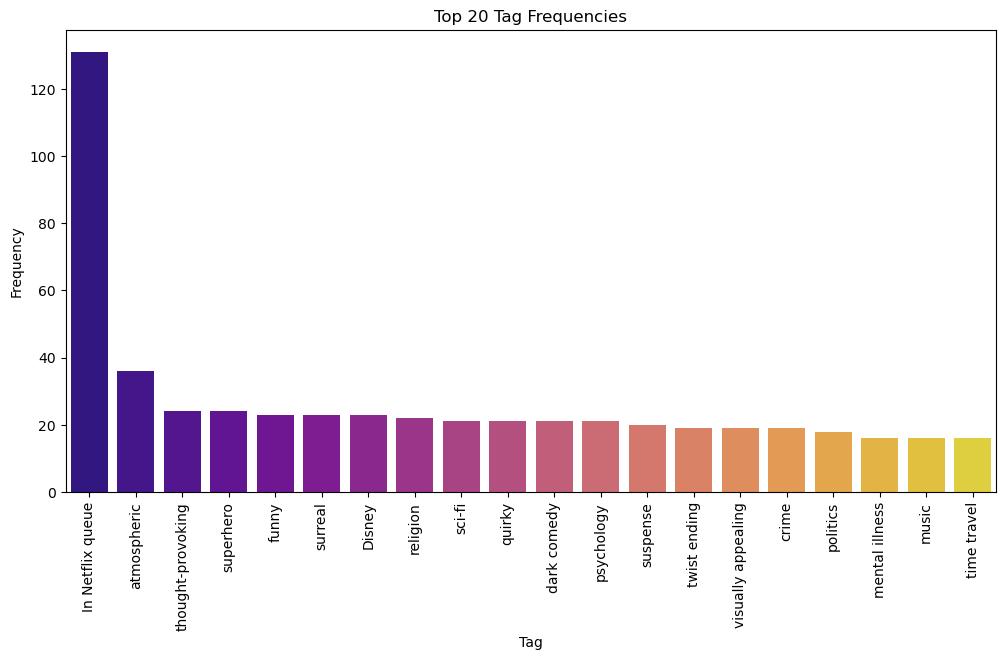

In [13]:
tag_counts = data_tags['tag'].value_counts()

# Plot the tag frequency distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=tag_counts.index[:20], y=tag_counts.values[:20], palette='plasma')
plt.title('Top 20 Tag Frequencies')
plt.xlabel('Tag')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

In [14]:
genre_tfidf = TfidfVectorizer(stop_words='english')
genre_matrix = genre_tfidf.fit_transform(data_movies['genres'])

In [15]:
genre_cosine_sim = cosine_similarity(genre_matrix, genre_matrix)

In [16]:
def genre_recommendation(movie_id, top_n=5):
    movie_idx = data_movies[data_movies['movieId'] == movie_id].index[0]
    sim_scores = list(enumerate(genre_cosine_sim[movie_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    recommended_movie_ids = [data_movies.iloc[i[0]]['movieId'] for i in sim_scores[1:top_n+1]]

    recommended_movie_names = data_movies[data_movies['movieId'].isin(recommended_movie_ids)]['title'].tolist()
    return recommended_movie_names
    
    

In [17]:
tagged_movies = data_tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()

In [18]:
tagged_movies = tagged_movies.merge(data_movies[['movieId']], on='movieId', how='right')

In [19]:
tag_tfidf = TfidfVectorizer(stop_words='english')
tag_matrix = tag_tfidf.fit_transform(tagged_movies['tag'].fillna(''))

In [20]:
tag_cosine_sim = cosine_similarity(tag_matrix, tag_matrix)

In [21]:
def tag_recommendation(movie_id, top_n=5):
    movie_idx = tagged_movies[tagged_movies['movieId'] == movie_id].index[0]
    sim_scores = list(enumerate(tag_cosine_sim[movie_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    recommended_movie_ids = [tagged_movies.iloc[i[0]]['movieId'] for i in sim_scores[1:top_n+1]]
    
    recommended_movie_names = data_movies[data_movies['movieId'].isin(recommended_movie_ids)]['title'].tolist()
    return recommended_movie_names

In [22]:
movie_id = 1
movie_title = data_movies[data_movies['movieId'] == movie_id]['title'].iloc[0]

print(f"Movie Title for movie_id {movie_id}: {movie_title}")

genre_recs = genre_recommendation(movie_id)
tag_recs = tag_recommendation(movie_id)

print("Genre-based Recommendations:")
for movie in genre_recs:
    print(movie)

print("\nTag-based Recommendations:")
for movie in tag_recs:
    print(movie)

Movie Title for movie_id 1: Toy Story (1995)
Genre-based Recommendations:
Antz (1998)
Toy Story 2 (1999)
Adventures of Rocky and Bullwinkle, The (2000)
Emperor's New Groove, The (2000)
Monsters, Inc. (2001)

Tag-based Recommendations:
Bug's Life, A (1998)
Toy Story 2 (1999)
Up (2009)
Big Hero 6 (2014)
Guardians of the Galaxy 2 (2017)


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [24]:
data_movies['genres'] = data_movies['genres'].fillna('').apply(lambda x: ' '.join(x.split('|')))

In [25]:

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
genre_matrix = tfidf_vectorizer.fit_transform(data_movies['genres'])

In [26]:
data_ratings_avg = data_ratings.groupby('movieId')['rating'].mean().reset_index()
data_movies = data_movies.merge(data_ratings_avg, on='movieId', how='left')
data_movies['rating'] = data_movies['rating'].fillna(data_movies['rating'].mean())

In [27]:
data_movies['scaled_rating'] = data_movies['rating'] / data_movies['rating'].max()

In [28]:
weighted_genre_matrix = genre_matrix.multiply(data_movies['scaled_rating'].values[:, None])

In [29]:
content_cosine_sim = cosine_similarity(weighted_genre_matrix, weighted_genre_matrix)

In [30]:
def genre_plus_rating_recommendation(movie_id, top_n=5):
    try:
        # Find the index of the movie
        movie_idx = data_movies[data_movies['movieId'] == movie_id].index[0]
        
        # Retrieve similarity scores for the movie
        sim_scores = list(enumerate(content_cosine_sim[movie_idx]))
        
        # Sort by similarity scores in descending order
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        
        # Get the top N recommendations (excluding the input movie itself)
        recommended_movie_ids = [data_movies.iloc[i[0]]['movieId'] for i in sim_scores[1:top_n + 1]]
        
        # Retrieve the movie titles
        recommended_movie_names = data_movies[data_movies['movieId'].isin(recommended_movie_ids)]['title'].tolist()
        return recommended_movie_names
    except IndexError:
        return ["Movie not found in the dataset."]

In [31]:
movie_id = 1  # Toy Story (1995)
movie_title = data_movies[data_movies['movieId'] == movie_id]['title'].iloc[0]
print(f"Movie Title for movie_id {movie_id}: {movie_title}")

recommendations = genre_plus_rating_recommendation(movie_id)
print("\nGenre + Rating Weighted Recommendations:")
for movie in recommendations:
    print(movie)

Movie Title for movie_id 1: Toy Story (1995)

Genre + Rating Weighted Recommendations:
Antz (1998)
Toy Story 2 (1999)
Adventures of Rocky and Bullwinkle, The (2000)
Emperor's New Groove, The (2000)
Monsters, Inc. (2001)
